## Plot the rifts on imagery 

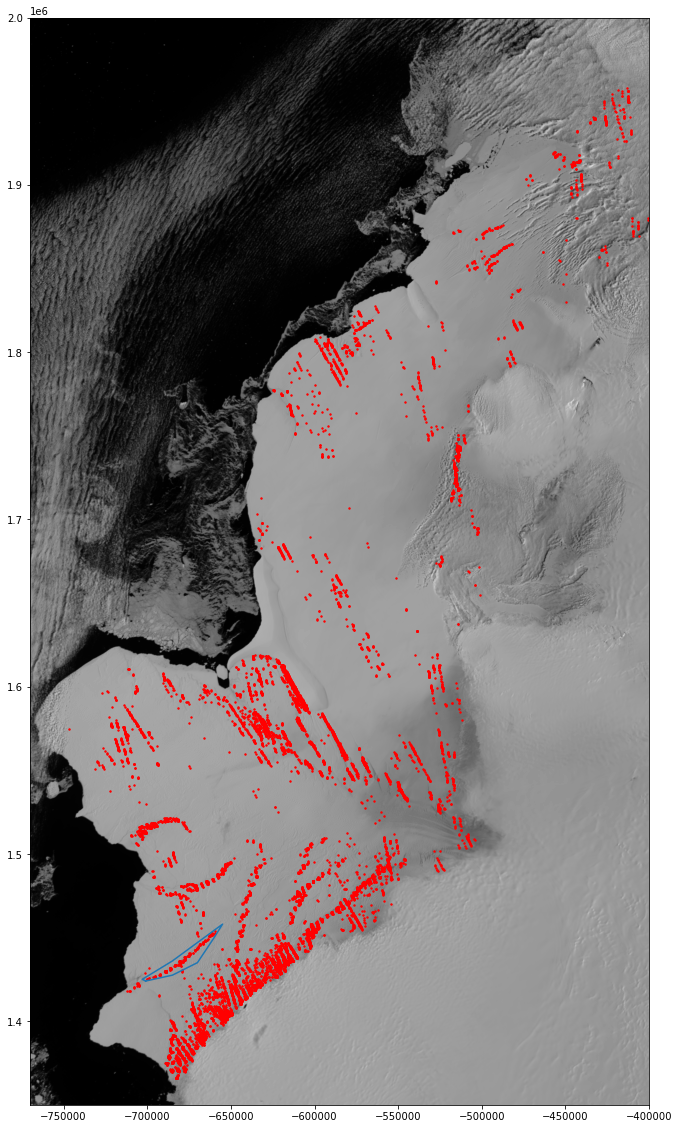

In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.colors as colors
import pickle

shelf_name = 'brunt'
# Load the rift observations
rift_obs_output_file_name = shelf_name + '_rift_obs.pickle'
with open(rift_obs_output_file_name, 'rb') as handle:
    rift_obs = pickle.load(handle)

image_file = 'riise_2020028_1615_modis_ch02.tif'
# image_file = '/Users/lipovsky/Downloads/riise_2020028_1615_modis_ch02.tif'

# Plot catalog over imagery
fig2,ax2 = plt.subplots(figsize=(20,20))
sat_data = rasterio.open(image_file)
show(sat_data,cmap="gray",ax=ax2)
ax2.scatter(rift_obs['x-centroid'] ,rift_obs['y-centroid'] ,s=2,c='r')

# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]

# This is a good window for all of brunt-riiser-ekstrom
window_x = [-7.7e5,-4.0e5]
window_y = [1.35e6,2e6]

plt.ylim(window_y)
plt.xlim(window_x)



# Make a bounding box and only look at the points within the box

from shapely.geometry import Point, Polygon

coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy
plt.plot(box_x,box_y)
plt.show()

## Load ITS_LIVE velocities

In [2]:
from netCDF4 import Dataset    
# d = Dataset('/Users/lipovsky/Downloads/ANT_G0120_0000.nc', 'r')
d = Dataset('ANT_G0120_0000.nc', 'r')
# print(d.variables['vx'])
itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later
from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)





# Calculate strains

dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])


## Plot just the Halloween crack  against the ITS_LIVE velocities

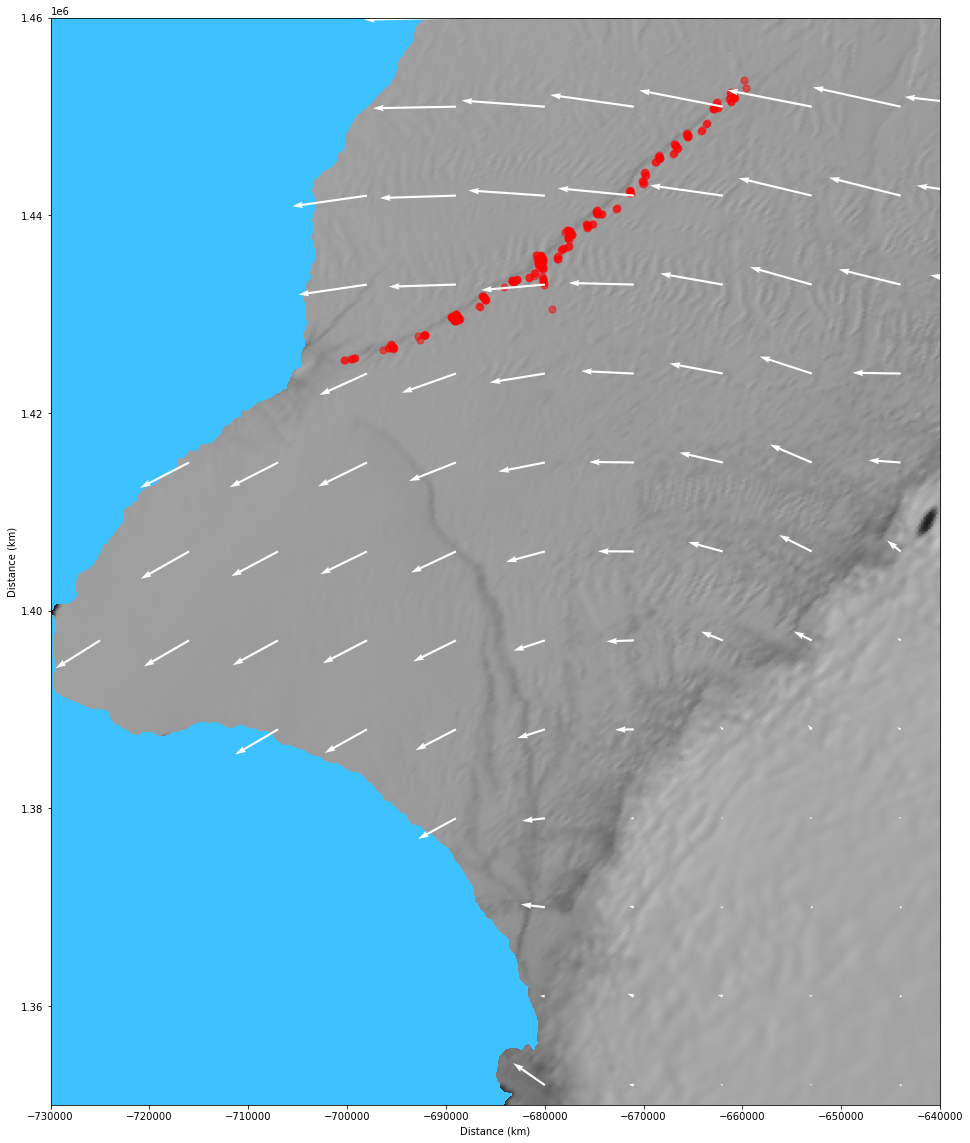

In [4]:
from matplotlib import cm
fig3,ax3=plt.subplots(figsize=(20,20))

# Subset the data to the Halloween Crack polygon
ho = rift_obs[rift_obs.within(poly)]

skip=75
plt.scatter(ho['x-centroid'] ,ho['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))
show(sat_data,cmap="gray",ax=ax3)
c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.axis('image')
plt.ylim(window_y_halloween)
plt.xlim(window_x_halloween)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.show()

## Calculate rift widths and axis angles

A big assumption here is that we already have measured the orientation of the rift.  Ideally, this would be done automatically.  For now, I have just written a script to choose the rift axis manually.

In [17]:
from shapely.ops import nearest_points
from pyproj import Geod
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( 'halloween.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []
for index, row in ho.iterrows():
    azimuth.append(estimate_local_rift_orientation(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - ho['azimuth']))) * ho['width']

# These are the angles of the rift axis
ho['rift-angle'] = pd.Series(np.array(azimuth), index=ho.index)
ho['rift-angle-xy'] = pd.Series(np.array(azimuth), index=ho.index)
ho['actual-width'] = pd.Series(np.array(actual_width), index=ho.index)

## Loop through observations
At each time-step: 1) add new observations, 2) advect old observations, 3) merge observations if they are close enough


In [18]:
# This version uses pandas in all its glory

time_vector = np.sort(np.unique(ho.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([])})

for t,i in zip(time_vector,np.arange(len(time_vector))):
    new_obs = ho[ho['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y']).diagonal()
        vy_new = vy_interp(state_vector['x'],state_vector['y']).diagonal()
        
        # Calculate strain rates
        e11 = vx_x(state_vector['x'],state_vector['y']).diagonal()
        e12 = ( vx_y(state_vector['x'],state_vector['y']).diagonal() 
              + vy_x(state_vector['x'],state_vector['y']).diagonal() ) / 2
        e22 = vy_y(state_vector['x'],state_vector['y']).diagonal()
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))

0. Found 2 new observations at time 2018-10-16 17:43:10.115692+00:00 with dt=inf
1. Found 6 new observations at time 2018-10-17 04:36:21.099482+00:00 with dt=0.0012418873358557051
2. Found 8 new observations at time 2018-11-10 16:27:49.992814+00:00 with dt=0.06706114829175856
3. Found 10 new observations at time 2018-11-15 03:12:21.335674+00:00 with dt=0.012176824056962507
4. Found 2 new observations at time 2018-12-13 14:55:15.839319+00:00 with dt=0.07799625141471468
5. Found 8 new observations at time 2018-12-14 01:48:05.531424+00:00 with dt=0.0012412126430717165
6. Found 2 new observations at time 2019-01-07 13:39:44.363714+00:00 with dt=0.06706146323833244
7. Found 5 new observations at time 2019-03-10 10:43:36.386782+00:00 with dt=0.16941186982115242
8. Found 6 new observations at time 2019-03-18 21:19:46.881140+00:00 with dt=0.02311235627417801
9. Found 8 new observations at time 2019-04-12 09:11:15.277560+00:00 with dt=0.06706113254556748
10. Found 3 new observations at time 201

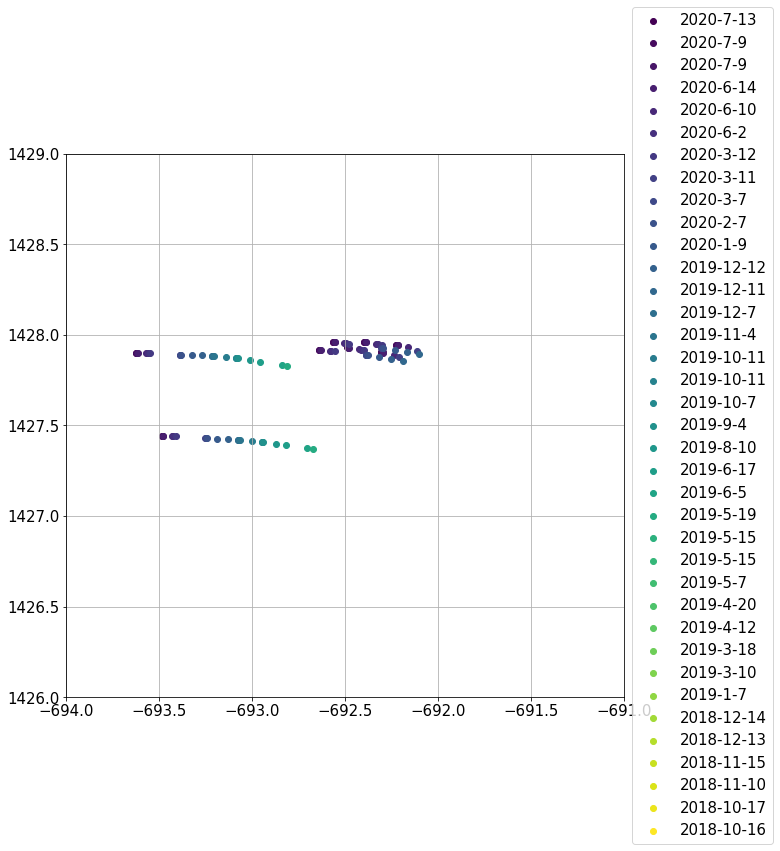

In [19]:
fig7,ax7 = plt.subplots(figsize=(10,10))
color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x']/1e3,item['y']/1e3,color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlim((-694,-691))
plt.ylim((1426,1429))
plt.show()

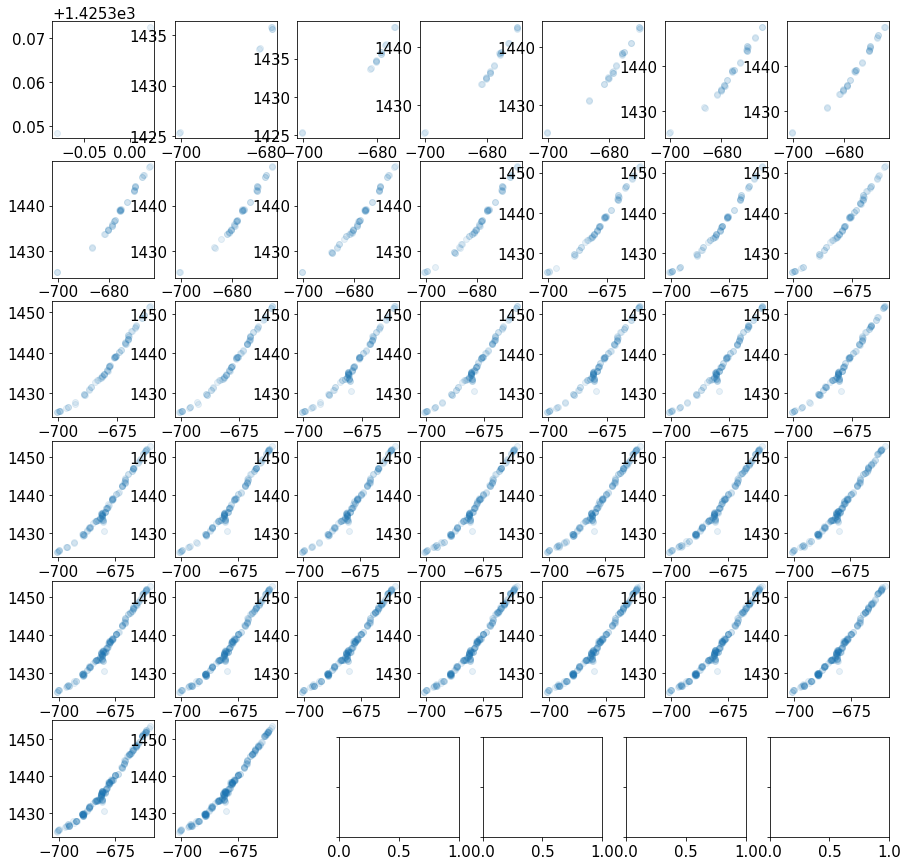

In [20]:
fig9,ax9 = plt.subplots(7, 6,sharex='all', sharey='all',figsize=(15,15))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    plt.subplot(6,7,1+i)
    plt.scatter(item['x']/1e3,item['y']/1e3,alpha=0.1)
plt.show()

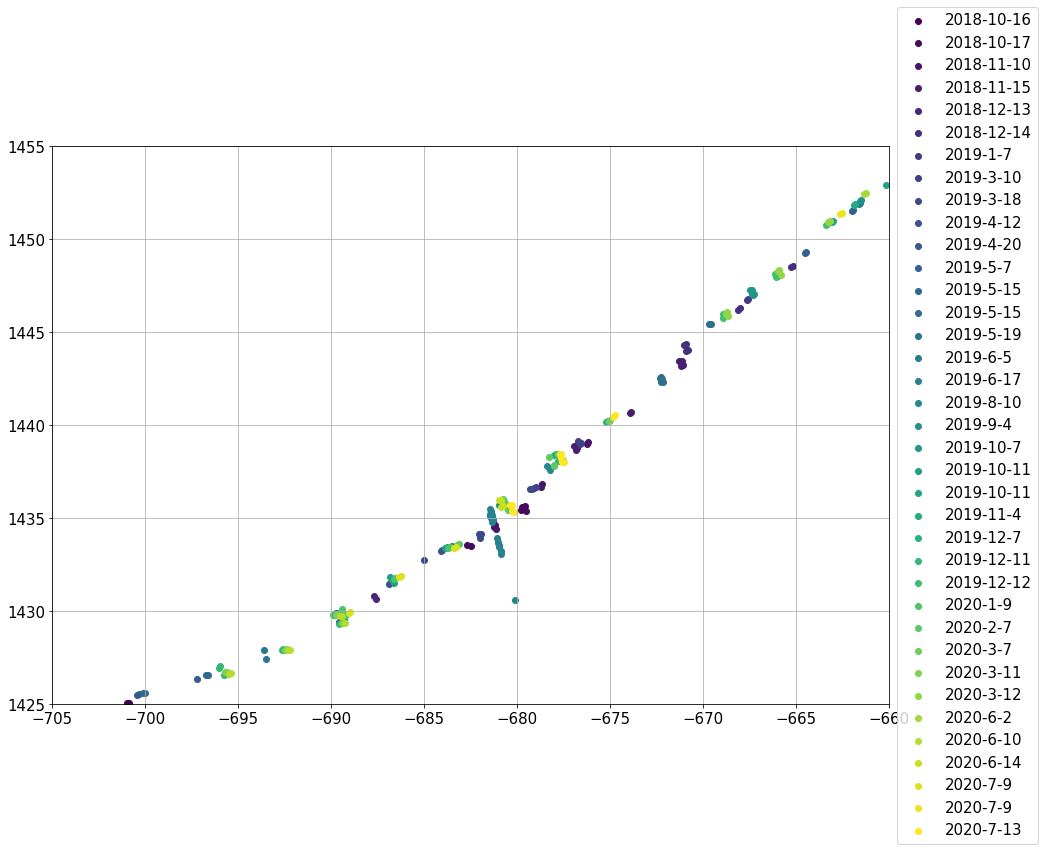

In [25]:
# Plot a snapshot
fig10,ax10 = plt.subplots(figsize=(15,15))
item = list_of_state_vectors[-1]

color=iter(cm.viridis(np.linspace(0,1,len(time_vector))))
for t in time_vector:
    c=next(color)
    plt.scatter(item[item['t']==t]['x']/1e3,
                item[item['t']==t]['y']/1e3,
                color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.axis('image')
plt.xlim((-705,-660))
plt.ylim((1425,1455))
plt.show()

<ipython-input-23-6d9557a34068>:7: RuntimeWarning: divide by zero encountered in log10
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
/home/ec2-user/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ec2-user/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start


<Figure size 432x288 with 0 Axes>

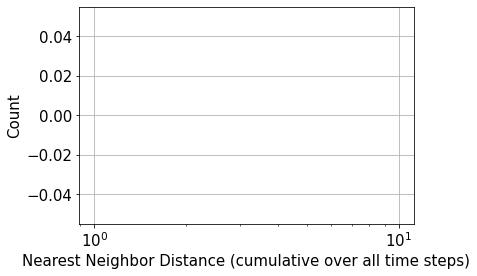

In [23]:
# How close are rift observations?

hist, bins, _ = plt.hist(seperation_list, bins=20)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.clf()
fig8 = plt.subplots()
plt.hist(seperation_list, bins=logbins)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Nearest Neighbor Distance (cumulative over all time steps)')
plt.ylabel('Count')
plt.grid()
plt.rcParams.update({'font.size': 15})
plt.show()

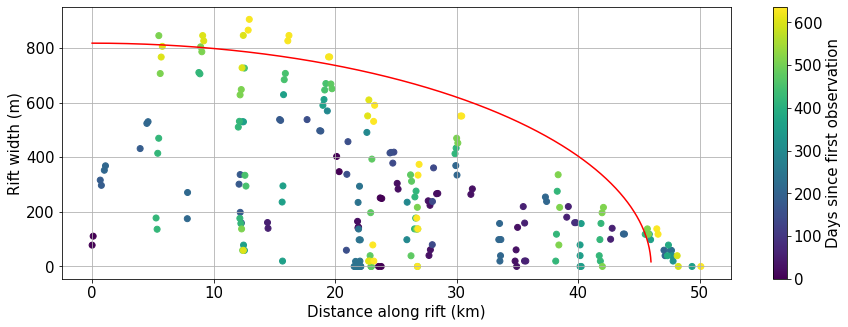

In [24]:
# How does rift width vary?
latest = list_of_state_vectors[-1]

xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )
fig12 = plt.subplots(figsize=(15,5))
c=plt.scatter(dist/1e3,latest['w'],c=times,label=latest['t'])
xx = np.arange(0,46,0.01)
plt.plot(xx,800*np.sqrt(46**2 - xx**2)/45,'-r')
cbar=plt.colorbar(c)
cbar.set_label('Days since first observation')
plt.xlabel('Distance along rift (km)')
plt.ylabel('Rift width (m)')
plt.grid()
plt.show()

In [ ]:
# How different are expected-versus-actual rift widths?